In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join, basename,exists
from glob import glob
from tqdm import tqdm

from infrasound import prep, mseed2arr, prep_wx, daily_power, daily_hour_power, slice_power

from obspy import read
from scipy.signal import correlate, correlation_lags, butter, filtfilt, spectrogram
from scipy.stats import pearsonr
from numpy.fft import fft, fftfreq, ifft, fftshift
import statsmodels.api as sm

In [6]:
in_dir = '/home/zacharykeskinen/data/infrasound/infrasound/processed'
in_dir = '../../data/banner/infrasound/processed'
csv_dir = '../../data/csvs/powers/'

def get_hz(fp):
    return fp.split('_')[-1].split('.')[0]

def dB_convert(series):
    return 10*np.log10(series.values/np.nanmax(series.values))

def lm(df):
    dB = dB_convert(df.Power)
    SD = sm.add_constant(df.SnowDepth.values, prepend=False)
    dB = dB[~np.isnan(df.SnowDepth.values)]
    SD = SD[~np.isnan(df.SnowDepth.values)]
    mod = sm.OLS(dB, SD)
    res = mod.fit()
    intercept = res.params[1]
    slope = res.params[0]
    slope_p = res.pvalues[0]
    return intercept, slope, slope_p


In [4]:
in_dir = '/home/zacharykeskinen/data/infrasound/infrasound/processed'
in_dir = '../../data/banner/infrasound/processed'
csv_dir = '../../data/csvs/powers/'

days, stats = prep(in_dir)
wx = prep_wx()

In [ ]:
freqs = [[1,10],[10,20],[20,30],[30,40],[40,50]]
# freqs = [[20,29]]
for f_low, f_high in freqs:
    df = pd.DataFrame()
    for i, (day, fps) in tqdm(enumerate(days.items()), desc = f'Powers for {f_low}-{f_high}', total = len(days), unit='Day'):
        if i == i:
            for j, (height, fp) in enumerate(fps.items()):
                if height == height:
                    arr = mseed2arr(fp, filtered = False)
                    snow_depth = wx.loc[pd.to_datetime(day, format='%y%m%d')]['SD_m']
                    snow_diff = snow_depth - height
                    p = daily_power(arr, f_low, f_high)
                    df = df.append({'SnowDepth':snow_diff, 'Power':p}, ignore_index=True)
    df.to_csv(join(csv_dir, f'depth_daily_power_{f_low}-{f_high}.csv'))

Powers for 40-50: 100%|██████████| 104/104 [13:57<00:00,  8.05s/Day]


In [28]:
freqs = [[1,10],[10,20],[20,30],[30,40],[40,50]]
freqs = [[1,99]]
# freqs = [[1,10], [40,50]]
for f_low, f_high in freqs:
    df = pd.DataFrame()
    for i, (day, fps) in tqdm(enumerate(days.items()), desc = f'Powers for {f_low}-{f_high}', total = len(days), unit='Day'):
        if i == i:
            for j, (height, fp) in enumerate(fps.items()):
                if height == height:
                    arr = mseed2arr(fp, filtered = False)
                    if int(arr.size/24) == arr.size/24:
                        snow_depth = wx.loc[pd.to_datetime(day, format='%y%m%d')]['SD_m']
                        snow_diff = snow_depth - height
                        p = daily_hour_power(arr, f_low, f_high)
                        for i in p:
                            d = {'SnowDepth':snow_diff, 'Power':i}
                            df = df.append(d, ignore_index=True)
    df.to_csv(join(csv_dir, f'depth_hour_power_{f_low}-{f_high}.csv'))

Powers for 1-99: 100%|██████████| 104/104 [06:16<00:00,  3.62s/Day]


In [5]:
daily_fps = glob(join(csv_dir,'depth_daily*'))
hourly_fps = glob(join(csv_dir,'depth_hour*'))
daily_fps.sort()
hourly_fps.sort()
def get_hz(fp):
    return fp.split('_')[-1].split('.')[0]

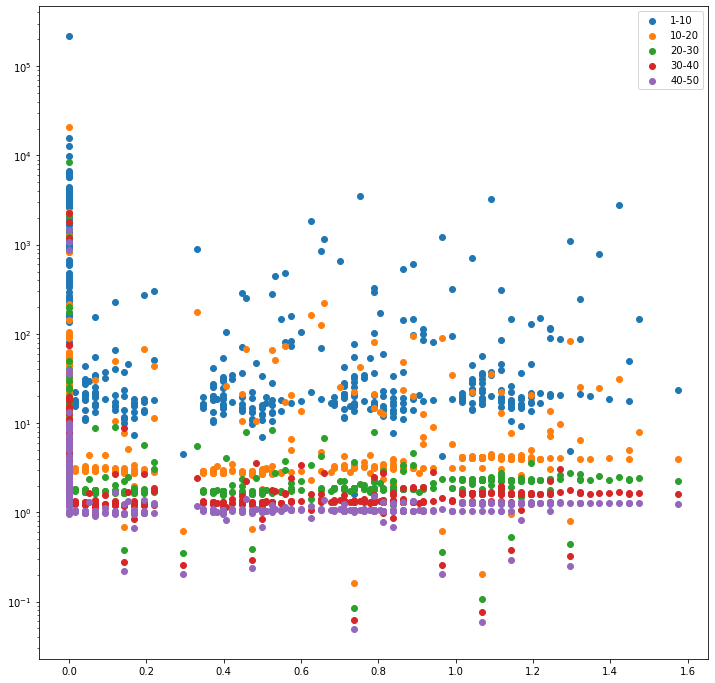

In [ ]:
plt.figure(figsize = (12,12))
for fp in daily_fps:
    df = pd.read_csv(fp)
    df.loc[df.SnowDepth <0, 'SnowDepth'] = 0
    plt.scatter(df.SnowDepth, df.Power, label = get_hz(fp))
    plt.legend()
    plt.yscale('log')

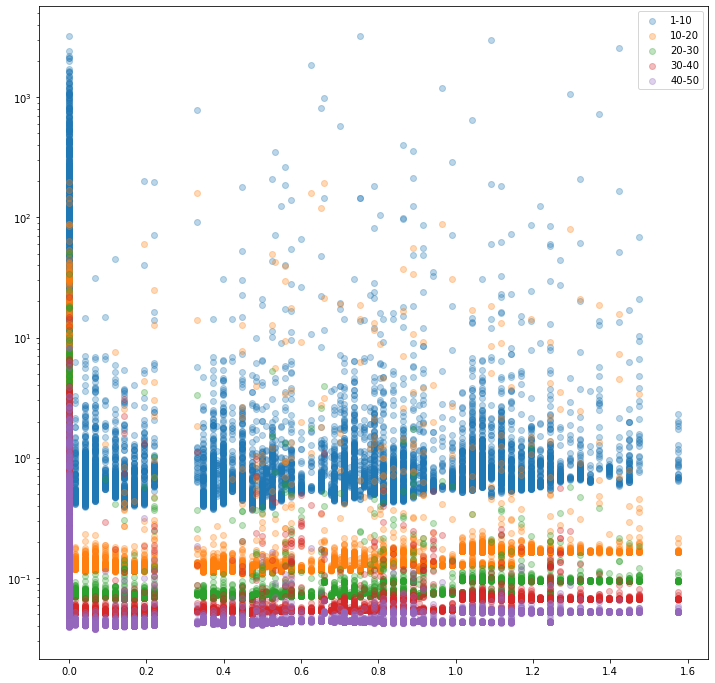

In [ ]:
plt.figure(figsize = (12,12))
for fp in hourly_fps:
    df = pd.read_csv(fp)
    df.loc[df.SnowDepth <0, 'SnowDepth'] = 0
    plt.scatter(df.SnowDepth, df.Power, label = get_hz(fp), alpha = 0.3)
    plt.legend()
    plt.yscale('log')

No handles with labels found to put in legend.


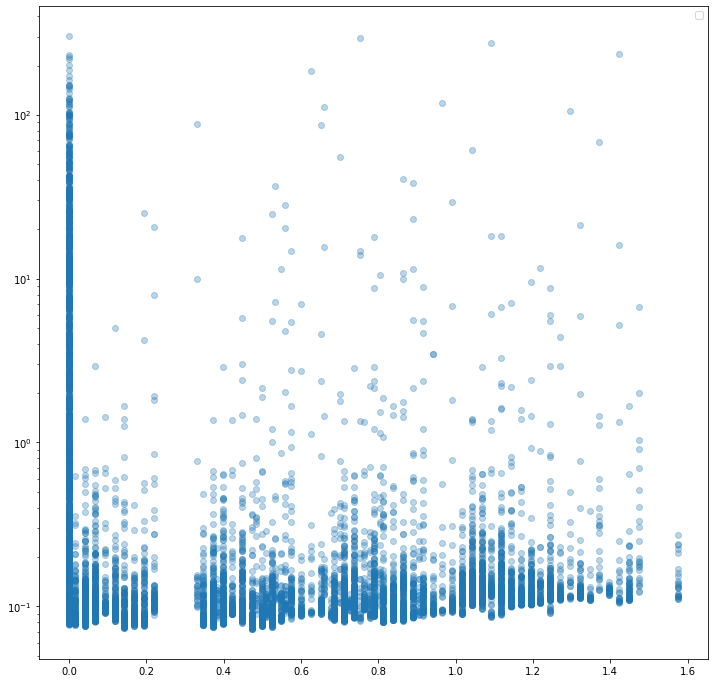

In [29]:
plt.figure(figsize = (12,12))

df = pd.read_csv(join(csv_dir, 'depth_hour_power_1-99.csv'))
df.loc[df.SnowDepth <0, 'SnowDepth'] = 0
plt.scatter(df.SnowDepth, df.Power, label = get_hz(fp), alpha = 0.3)
plt.legend()
plt.yscale('log')

In [3]:
freqs = [[1,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70],[70,80],[80,90],[90,99]]
freqs = [[50,60],[60,70],[70,80],[80,90],[90,99]]
freqs = [[1,50],[50,99]]
freqs = [[1,99]]
wind_sec = 10
sps = 200
window = wind_sec*sps

for f_low, f_high in freqs:
    df = pd.DataFrame()
    for i, (day, fps) in tqdm(enumerate(days.items()), desc = f'Powers for {f_low}-{f_high}', total = len(days), unit='Day'):
        if i == i:
            snow_depth = wx.loc[pd.to_datetime(day, format='%y%m%d')]['SD_m']
            for j, (height, fp) in enumerate(fps.items()):
                snow_diff = snow_depth - height
                if height != 0.33:
                    ref_height = 0.33
                else:
                    ref_height = 0.33

                arr = mseed2arr(fp, filtered = True)
                if int(arr.size/window) == arr.size/window:
                    arr = arr.reshape(-1,window)
                    ref_arr = mseed2arr(fps[ref_height], filtered = True).reshape(-1,window)

                    corr = np.array([pearsonr(i,j)[0] for (i, j) in zip(arr,ref_arr)])
                    cut_arr = arr[(corr > .9), :]
                    cor_windows = cut_arr[np.any(cut_arr, axis = 1) > np.quantile(arr, 0.999)]
                    powers = slice_power(cor_windows, f_low=f_low, f_high=f_high)
                    for i in powers:
                        d = {'SnowDepth':snow_diff, 'Power':i}
                        df = df.append(d, ignore_index=True)
    df.to_csv(join(csv_dir, f'depth_corr_power_{f_low}-{f_high}.csv'))


Powers for 1-99: 100%|██████████| 104/104 [47:12<00:00, 27.24s/Day]


[]
SnowDepth
-0.2000    0.004748
-0.0094    0.237495
 0.0002    0.006562
 0.0162    0.001876
 0.0416    0.002735
 0.0670    0.003208
 0.1178    0.002812
 0.1430    0.009603
 0.1432    0.002283
 0.1684    0.002221
 0.3716    0.002030
 0.3814    0.002246
 0.3970    0.014513
 0.4478    0.027899
 0.4732    0.002554
 0.4986    0.004568
 0.5240    0.004472
 0.5338    0.105399
 0.5592    0.018925
 0.6002    0.014205
 0.6510    0.022331
 0.6862    0.001970
 0.7018    0.212141
 0.7116    0.003561
 0.7370    0.004582
 0.7878    0.043025
 0.8034    0.038083
 0.8132    0.001568
 0.8384    0.002260
 0.8386    0.001969
 0.8640    0.002038
 0.8892    0.143102
 0.8894    0.026218
 0.9148    0.038254
 0.9910    0.074231
 1.0162    0.001976
 1.0416    0.005933
 1.0924    0.006221
 1.0926    0.942010
 1.1178    0.002845
 1.1180    0.005909
 1.1432    0.004566
 1.1686    0.002307
 1.1940    0.015368
 1.2194    0.001574
 1.2448    0.014899
 1.2956    0.435435
 1.3464    0.002565
 1.3972    0.001867
 1.5750

(0.0, 2.0)

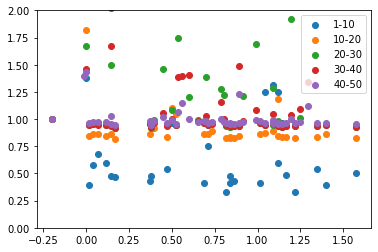

In [ ]:
corr_csv = glob(join(csv_dir, 'depth_corr*'))
corr_csv.sort()
for fp in corr_csv:
    df = pd.read_csv(fp)
    df.loc[df.SnowDepth <-0.2, 'SnowDepth'] = -0.2
    grouped_power = df.groupby('SnowDepth').aggregate('mean')
    print(grouped_power.loc[grouped_power.index == 0, 'Power'].values)
    print(grouped_power.Power)
    norm_power = grouped_power.Power/grouped_power.loc[grouped_power.index == -0.2, 'Power'].values
    plt.scatter(grouped_power.index, norm_power, label = get_hz(fp), alpha = 1)
plt.legend(loc = 'upper right')
# plt.yscale('log')
plt.ylim(0, 2)

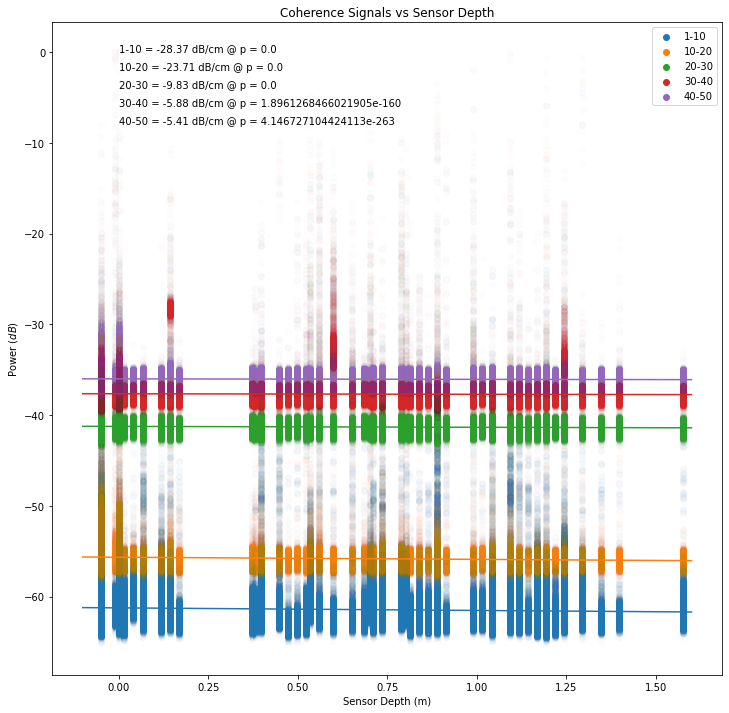

In [54]:
plt.figure(figsize=(12,12))
corr_csv = glob(join(csv_dir, 'depth_corr*'))
corr_csv.sort()
approved_list = ['1-10','10-20','20-30','30-40','40-50']
i = 0
for fp in corr_csv:
    if get_hz(fp) in approved_list:
        df = pd.read_csv(fp)
        df.loc[df.SnowDepth <-0.2, 'SnowDepth'] = -0.05
        plt.scatter(df.SnowDepth, dB_convert(df.Power), alpha = .01, label = get_hz(fp))
        int, slope, p = lm(df)
        x = np.linspace(-0.1, 1.6, 500)
        y = int + slope*x
        plt.plot(x,y)
        plt.text(0, 0-i, f'{get_hz(fp)} = {round(slope*100,2)} dB/cm @ p = {p}')
        i += 2
leg = plt.legend(loc = 'upper right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
#plt.yscale('log')
#plt.ylim(1e-7,1e-1)
plt.xlabel('Sensor Depth (m)')
plt.ylabel('Power ($dB$)')
plt.title('Coherent Signals vs Sensor Depth')
plt.show()

In [32]:
freqs = [[1,10],[90,99]]
wind_sec = 10
sps = 200
window = wind_sec*sps

for f_low, f_high in freqs:
    df = pd.DataFrame()
    for i, (day, fps) in tqdm(enumerate(days.items()), desc = f'Powers for {f_low}-{f_high}', total = len(days), unit='Day'):
        if i == i:
            snow_depth = wx.loc[pd.to_datetime(day, format='%y%m%d')]['SD_m']
            dens = wx.loc[pd.to_datetime(day, format='%y%m%d')]['SWE_m']/snow_depth
            for j, (height, fp) in enumerate(fps.items()):
                snow_diff = (snow_depth - height)*dens
                if height != 0.33:
                    ref_height = 0.33
                else:
                    ref_height = 0.33

                arr = mseed2arr(fp, filtered = True)
                if int(arr.size/window) == arr.size/window:
                    arr = arr.reshape(-1,window)
                    ref_arr = mseed2arr(fps[ref_height], filtered = True).reshape(-1,window)

                    corr = np.array([pearsonr(i,j)[0] for (i, j) in zip(arr,ref_arr)])
                    cut_arr = arr[(corr > .9), :]
                    cor_windows = cut_arr[np.any(cut_arr, axis = 1) > np.quantile(arr, 0.999)]
                    powers = slice_power(cor_windows, f_low=f_low, f_high=f_high)
                    for i in powers:
                        d = {'SnowVolume':snow_diff, 'Power':i}
                        df = df.append(d, ignore_index=True)
    df.to_csv(join(csv_dir, f'volume_corr_power_{f_low}-{f_high}.csv'))


Powers for 1-10:  45%|████▌     | 47/104 [13:29<16:21, 17.22s/Day]


KeyboardInterrupt: 

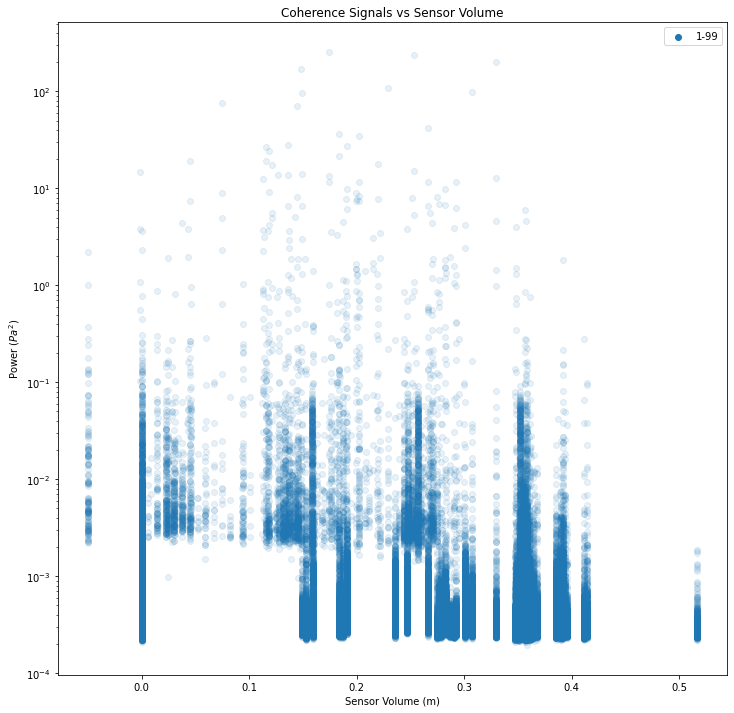

In [29]:
plt.figure(figsize=(12,12))
corr_csv = glob(join(csv_dir, 'volume_corr*'))
corr_csv.sort()
for fp in corr_csv:
    if get_hz(fp) == '1-99':
        df = pd.read_csv(fp)
        df.loc[df.SnowVolume <-0.05, 'SnowVolume'] = -0.05
        plt.scatter(df.SnowVolume, df.Power, alpha = .1, label = get_hz(fp))
leg = plt.legend(loc = 'upper right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.yscale('log')
#plt.ylim(1e-7,1e-1)
plt.xlabel('Sensor Volume (m)')
plt.ylabel('Power ($Pa^{2}$)')
plt.title('Coherence Signals vs Sensor Volume')
plt.show()

In [30]:
freqs = [[1,99]]
wind_sec = 10
sps = 200
window = wind_sec*sps

for f_low, f_high in freqs:
    df = pd.DataFrame()
    for i, (day, fps) in tqdm(enumerate(days.items()), desc = f'Powers for {f_low}-{f_high}', total = len(days), unit='Day'):
        if i == i:
            dens = wx.loc[pd.to_datetime(day, format='%y%m%d')]['SWE_m']/snow_depth
            for j, (height, fp) in enumerate(fps.items()):
                if height != 0.33:
                    ref_height = 0.33
                else:
                    ref_height = 0.33

                arr = mseed2arr(fp, filtered = True)
                if int(arr.size/window) == arr.size/window:
                    arr = arr.reshape(-1,window)
                    ref_arr = mseed2arr(fps[ref_height], filtered = True).reshape(-1,window)

                    corr = np.array([pearsonr(i,j)[0] for (i, j) in zip(arr,ref_arr)])
                    cut_arr = arr[(corr > .9), :]
                    cor_windows = cut_arr[np.any(cut_arr, axis = 1) > np.quantile(arr, 0.999)]
                    powers = slice_power(cor_windows, f_low=f_low, f_high=f_high)
                    for i in powers:
                        d = {'SnowDensity':dens, 'Power':i}
                        df = df.append(d, ignore_index=True)
    df.to_csv(join(csv_dir, f'density_corr_power_{f_low}-{f_high}.csv'))


Powers for 1-99: 100%|██████████| 104/104 [46:30<00:00, 26.83s/Day]


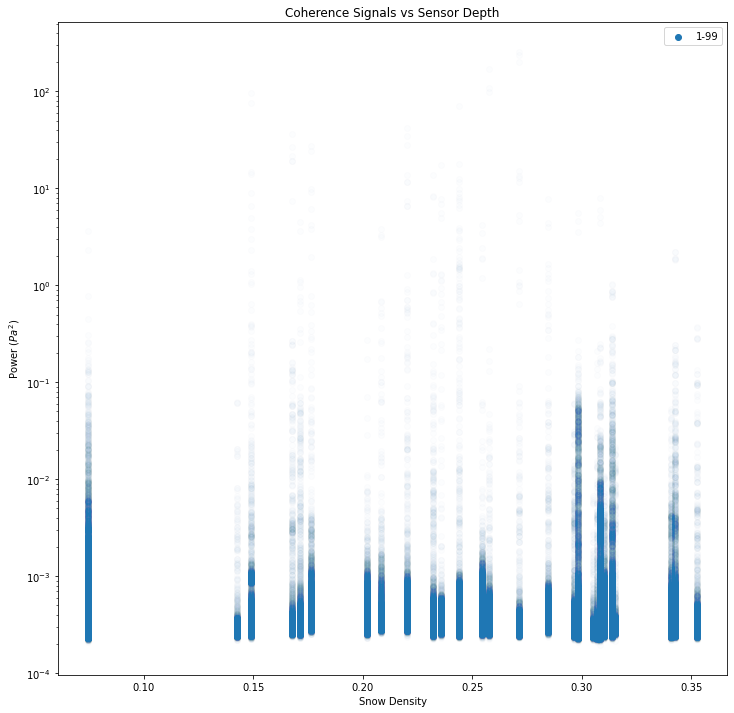

In [31]:
plt.figure(figsize=(12,12))
corr_csv = glob(join(csv_dir, 'density_corr*'))
corr_csv.sort()
for fp in corr_csv:
    if get_hz(fp) == '1-99':
        df = pd.read_csv(fp)
        df.loc[df.SnowDensity <-0.2, 'SnowDensity'] = -0.05
        plt.scatter(df.SnowDensity, df.Power, alpha = .01, label = get_hz(fp))
leg = plt.legend(loc = 'upper right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.yscale('log')
#plt.ylim(1e-7,1e-1)
plt.xlabel('Snow Density')
plt.ylabel('Power ($Pa^{2}$)')
plt.title('Coherence Signals vs Sensor Depth')
plt.show()